### 一、高斯贝叶斯和多项式朴素贝叶斯：

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.naive_bayes import GaussianNB, MultinomialNB  # 高斯贝叶斯和多项式朴素贝叶斯
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


# 1,加载数据：
iris_feature_E = 'sepal length', 'sepal width', 'petal length', 'petal width'
iris_feature_C = u'花萼长度', u'花萼宽度', u'花瓣长度', u'花瓣宽度'
iris_class = 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'
features = [2,3]

data = pd.read_csv('../DataSets/iris.data', header=None)
x = data[list(range(4))]
x = x[features]
y = pd.Categorical(data[4]).codes ## 直接将数据特征转换为0，1,2
print ("总样本数目：%d；特征属性数目：%d" % x.shape)


x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=14)
print ("训练数据集样本数目：%d, 测试数据集样本数目：%d" % (x_train.shape[0], x_test.shape[0]))

总样本数目：150；特征属性数目：2
训练数据集样本数目：120, 测试数据集样本数目：30


/home/jesse/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [2]:
# 2，高斯贝叶斯模型：
clf = Pipeline([
        ('sc', StandardScaler()),#标准化，把它转化成了高斯分布
        ('poly', PolynomialFeatures(degree=1)),
        ('clf', GaussianNB())])

clf.fit(x_train, y_train)   # 训练模型


y_train_hat = clf.predict(x_train)  
print ('训练集准确度: %.2f%%' % (100 * accuracy_score(y_train, y_train_hat))) # 计算准确率
y_test_hat = clf.predict(x_test)
print ('测试集准确度：%.2f%%' % (100 * accuracy_score(y_test, y_test_hat)))

训练集准确度: 95.83%
测试集准确度：96.67%


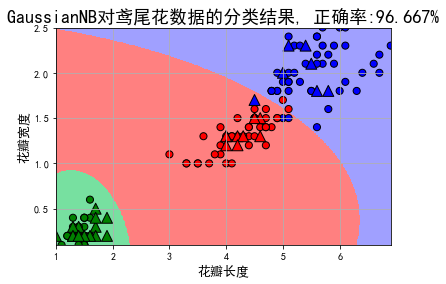

In [3]:
# 3，画图：
## 产生区域图
N, M = 500, 500     # 横纵各采样多少个值
x1_min1, x2_min1 = x_train.min()
x1_max1, x2_max1 = x_train.max()
x1_min2, x2_min2 = x_test.min()
x1_max2, x2_max2 = x_test.max()
x1_min = np.min((x1_min1, x1_min2))
x1_max = np.max((x1_max1, x1_max2))
x2_min = np.min((x2_min1, x2_min2))
x2_max = np.max((x2_max1, x2_max2))

t1 = np.linspace(x1_min, x1_max, N)
t2 = np.linspace(x2_min, x2_max, N)
x1, x2 = np.meshgrid(t1, t2)  # 生成网格采样点
x_show = np.dstack((x1.flat, x2.flat))[0] # 测试点

cm_light = mpl.colors.ListedColormap(['#77E0A0', '#FF8080', '#A0A0FF'])
cm_dark = mpl.colors.ListedColormap(['g', 'r', 'b'])
y_show_hat = clf.predict(x_show)                  # 预测值
y_show_hat = y_show_hat.reshape(x1.shape)


## 画图
plt.figure(facecolor='w')
plt.pcolormesh(x1, x2, y_show_hat, cmap=cm_light)     # 预测值的显示
plt.scatter(x_train[features[0]], x_train[features[1]], c=y_train, edgecolors='k', s=50, cmap=cm_dark)
plt.scatter(x_test[features[0]], x_test[features[1]], c=y_test, marker='^', edgecolors='k', s=120, cmap=cm_dark)
plt.xlabel(iris_feature_C[features[0]], fontsize=13)
plt.ylabel(iris_feature_C[features[1]], fontsize=13)
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.title(u'GaussianNB对鸢尾花数据的分类结果, 正确率:%.3f%%' % (100 * accuracy_score(y_test, y_test_hat)), fontsize=18)
plt.grid(True)
plt.show()

### 二、多项式和伯努利朴素贝叶斯：

In [4]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.datasets import fetch_20newsgroups#引入新闻数据包
from sklearn.feature_extraction.text import TfidfVectorizer#做tfidf编码
from sklearn.feature_selection import SelectKBest, chi2#卡方检验——特征筛选
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB # 多项式和伯努利的贝叶斯
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


# 1，定义基准模型方法：
def benchmark(clf,name):
    print (u'分类器：', clf)
    
    
    alpha_can = np.logspace(-2, 1, 10)  #  设置最优参数，并使用5折交叉验证获取最优参数值
    model = GridSearchCV(clf, param_grid={'alpha': alpha_can}, cv=5)
    m = alpha_can.size
    
    
    if hasattr(clf, 'alpha'):  # 如果模型有一个参数是alpha，进行设置
        model.set_params(param_grid={'alpha': alpha_can})
        m = alpha_can.size
    
    if hasattr(clf, 'n_neighbors'):  # 如果模型有一个k近邻的参数，进行设置
        neighbors_can = np.arange(1, 15)
        model.set_params(param_grid={'n_neighbors': neighbors_can})
        m = neighbors_can.size
    
    if hasattr(clf, 'C'):  # LinearSVC最优参数配置
        C_can = np.logspace(1, 3, 3)
        model.set_params(param_grid={'C':C_can})
        m = C_can.size
  
    if hasattr(clf, 'C') & hasattr(clf, 'gamma'):  # SVM最优参数设置
        C_can = np.logspace(1, 3, 3)
        gamma_can = np.logspace(-3, 0, 3)
        model.set_params(param_grid={'C':C_can, 'gamma':gamma_can})
        m = C_can.size * gamma_can.size
  
    if hasattr(clf, 'max_depth'):  # 设置深度相关参数，决策树
        max_depth_can = np.arange(4, 10)
        model.set_params(param_grid={'max_depth': max_depth_can})
        m = max_depth_can.size
       
    t_start = time()  # 模型训练
    model.fit(x_train, y_train)
    t_end = time()
    t_train = (t_end - t_start) / (5*m)
    print (u'5折交叉验证的训练时间为：%.3f秒/(5*%d)=%.3f秒' % ((t_end - t_start), m, t_train))
    print (u'最优超参数为：', model.best_params_)
        
    t_start = time()  # 模型预测
    y_hat = model.predict(x_test)
    t_end = time()
    t_test = t_end - t_start
    print (u'测试时间：%.3f秒' % t_test)
    
    train_acc = metrics.accuracy_score(y_train, model.predict(x_train))  # 模型效果评估
    test_acc = metrics.accuracy_score(y_test, y_hat)
    print (u'训练集准确率：%.2f%%' % (100 * train_acc))
    print (u'测试集准确率：%.2f%%' % (100 * test_acc))
    
    return t_train, t_test, 1-train_acc, 1-test_acc, name  # 返回结果(训练时间耗时，预测数据耗时，训练数据错误率，测试数据错误率, 名称)

In [5]:
# 2，数据加载
print (u'加载数据...')
t_start = time()

remove = ('headers', 'footers', 'quotes')  # 不要头部信息
categories = 'alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space'  # 保留这四类数据

data_train = fetch_20newsgroups(data_home='../DataSets/20news/',subset='train', categories=categories, shuffle=True, random_state=0, remove=remove)
data_test = fetch_20newsgroups(data_home='../DataSets/20news/',subset='test', categories=categories, shuffle=True, random_state=0, remove=remove)
print (u"完成数据加载过程.耗时:%.3fs" % (time() - t_start))

def size_mb(docs):  # 获取加载数据的相关信息
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

categories = data_train.target_names
data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print (u'数据类型：', type(data_train.data))
print("%d文本数量 - %0.3fMB (训练数据集)" % (len(data_train.data), data_train_size_mb))
print("%d文本数量 - %0.3fMB (测试数据集)" % (len(data_test.data), data_test_size_mb))
print (u'训练集和测试集使用的%d个类别的名称：' % len(categories))
print(categories)

x_train = data_train.data  # 数据重命名
y_train = data_train.target
x_test = data_test.data
y_test = data_test.target

print (u' -- 前5个文本 -- ')  # 输出前5个样本
for i in range(5):
    print (u'文本%d(属于类别 - %s)：' % (i+1, categories[y_train[i]]))
    print (x_train[i])
    print ('\n\n')

加载数据...
完成数据加载过程.耗时:4834.748s
数据类型： <class 'list'>
2034文本数量 - 2.428MB (训练数据集)
1353文本数量 - 1.800MB (测试数据集)
训练集和测试集使用的4个类别的名称：
['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
 -- 前5个文本 -- 
文本1(属于类别 - alt.atheism)：
If one is a vegan (a vegetarian taht eats no animal products at at i.e eggs, 
milk, cheese, etc., after about 3 years of a vegan diet, you need to start 
taking B12 supplements because b12 is found only in animals.) Acutally our 
bodies make B12, I think, but our bodies use up our own B12 after 2 or 3 
years.  
Lacto-oveo vegetarians, like myself, still get B12 through milk products 
and eggs, so we don't need supplements.
And If anyone knows more, PLEASE post it.  I'm nearly contridicting myself 
with the mish-mash of knowledge I've gleaned.



文本2(属于类别 - comp.graphics)：
Hi,
         I have a friend who is working on 2-d and 3-d object recognition. He is looking
for references describing algorithms on the following subject areas:

Thresholding
Edge Segmentat

In [6]:
# 3，文档转换为向量：要求输入的数据类型必须是list，list中的每条数据，单词是以空格分割开的
vectorizer = TfidfVectorizer(input='content', stop_words='english', max_df=0.5, sublinear_tf=True)
x_train = vectorizer.fit_transform(data_train.data)  # x_train是稀疏的，scipy.sparse.csr.csr_matrix
x_test = vectorizer.transform(data_test.data)
print (u'训练集样本个数：%d，特征个数：%d' % x_train.shape)
print (u'停止词:\n')
print(vectorizer.get_stop_words())
feature_names = np.asarray(vectorizer.get_feature_names())  # 获取最终的特征属性名称

训练集样本个数：2034，特征个数：26576
停止词:

frozenset({'always', 'someone', 'cannot', 'below', 'con', 'seems', 'again', 'become', 'an', 'hereafter', 'has', 'ltd', 'whence', 'found', 'bill', 'latter', 'along', 'fill', 'whereupon', 'themselves', 'at', 'during', 'them', 'our', 'own', 're', 'seeming', 'amount', 'two', 'many', 'their', 'anyhow', 'interest', 'and', 'find', 'before', 'my', 'why', 'yourself', 'she', 'empty', 'or', 'everything', 'down', 'several', 'made', 'were', 'whenever', 'those', 'without', 'so', 'nothing', 'thereby', 'such', 'the', 'however', 'as', 'hasnt', 'moreover', 'least', 'therein', 'anywhere', 'eight', 'much', 'either', 'every', 'often', 'while', 'show', 'none', 'side', 'thence', 'elsewhere', 'whose', 'ourselves', 'became', 'nor', 'noone', 'anyway', 'out', 'another', 'get', 'cry', 'six', 'further', 'fifty', 'her', 'perhaps', 'what', 'co', 'how', 'keep', 'off', 'ten', 'they', 'with', 'ours', 'first', 'besides', 'any', 'full', 'system', 'up', 'very', 'everyone', 'take', 'within', '

In [7]:
# 4，特征选择：
ch2 = SelectKBest(chi2, k=1000)
x_train = ch2.fit_transform(x_train, y_train)
x_test = ch2.transform(x_test)
feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]

In [8]:
# 5，使用不同的分类器对数据进行比较
print (u'分类器的比较：\n')
clfs = [
    [RidgeClassifier(), 'Ridge'],
    [KNeighborsClassifier(), 'KNN'],
    [MultinomialNB(), 'MultinomialNB'],
    [BernoulliNB(), 'BernoulliNB'],
    [RandomForestClassifier(n_estimators=200), 'RandomForest'],
    [SVC(), 'SVM'],
    [LinearSVC(loss='squared_hinge', penalty='l1', dual=False, tol=1e-4), 'LinearSVC-l1'],
    [LinearSVC(loss='squared_hinge', penalty='l2', dual=False, tol=1e-4), 'LinearSVC-l2']
]


result = []  # 将训练数据保存到一个列表中
for clf,name in clfs:    
    a = benchmark(clf,name)  # 计算算法结果    
    result.append(a)  # 追加到一个列表中，方便进行展示操作
    print ('\n')
result = np.array(result)  # 将列表转换为数组

分类器的比较：

分类器： RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)
5折交叉验证的训练时间为：4.474秒/(5*10)=0.089秒
最优超参数为： {'alpha': 0.46415888336127775}
测试时间：0.000秒
训练集准确率：92.63%
测试集准确率：75.76%


分类器： KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
5折交叉验证的训练时间为：9.173秒/(5*14)=0.131秒
最优超参数为： {'n_neighbors': 1}
测试时间：0.087秒
训练集准确率：96.51%
测试集准确率：50.55%


分类器： MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
5折交叉验证的训练时间为：0.138秒/(5*10)=0.003秒
最优超参数为： {'alpha': 0.01}
测试时间：0.001秒
训练集准确率：91.40%
测试集准确率：76.72%


分类器： BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
5折交叉验证的训练时间为：0.202秒/(5*10)=0.004秒
最优超参数为： {'alpha': 0.01}
测试时间：0.001秒
训练集准确率：88.64%
测试集准确率：74.28%


分类器： RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
   

/home/jesse/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


5折交叉验证的训练时间为：7.422秒/(5*3)=0.495秒
最优超参数为： {'C': 10.0}
测试时间：0.001秒
训练集准确率：96.31%
测试集准确率：72.28%


分类器： LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
5折交叉验证的训练时间为：0.852秒/(5*3)=0.057秒
最优超参数为： {'C': 10.0}
测试时间：0.001秒
训练集准确率：95.48%
测试集准确率：74.58%




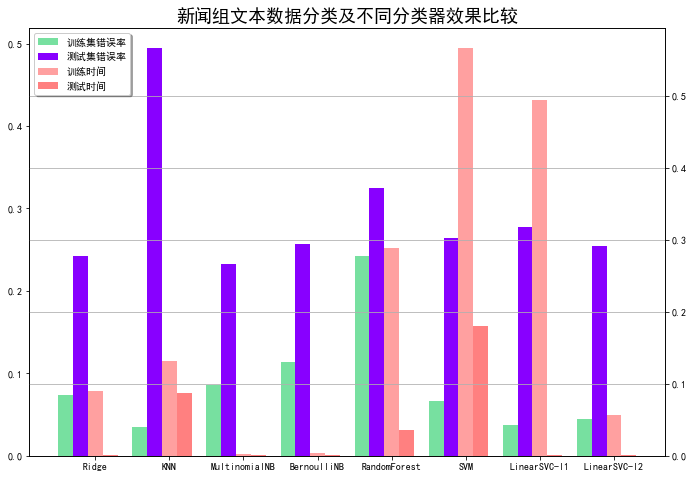

In [9]:
# 画图：
result = [[x[i] for x in result] for i in range(5)]
training_time, test_time, training_err, test_err, clf_names = result

training_time = np.array(training_time).astype(np.float)
test_time = np.array(test_time).astype(np.float)
training_err = np.array(training_err).astype(np.float)
test_err = np.array(test_err).astype(np.float)


x = np.arange(len(training_time))
plt.figure(figsize=(10, 7), facecolor='w')
ax = plt.axes()
b0 = ax.bar(x+0.1, training_err, width=0.2, color='#77E0A0')
b1 = ax.bar(x+0.3, test_err, width=0.2, color='#8800FF')
ax2 = ax.twinx()
b2 = ax2.bar(x+0.5, training_time, width=0.2, color='#FFA0A0')
b3 = ax2.bar(x+0.7, test_time, width=0.2, color='#FF8080')
plt.xticks(x+0.5, clf_names)
plt.legend([b0[0], b1[0], b2[0], b3[0]], (u'训练集错误率', u'测试集错误率', u'训练时间', u'测试时间'), loc='upper left', shadow=True)
plt.title(u'新闻组文本数据分类及不同分类器效果比较', fontsize=18)
plt.xlabel(u'分类器名称')
plt.grid(True)
plt.tight_layout(2)
plt.show()